# Heat pump modeling

In [1]:
#import fitz  # PyMuPDF
import matplotlib.pyplot as plt
import io
from PIL import Image

We use a RC model for the buildings. The equations that compose it are as follows:
\begin{align*}
    C \frac{dT}{dt} &= \dot{q} - \frac{T - T^{amb}}{R} \\
    \dot{q} &= \beta_{COP} \cdot P,
\end{align*}
where $C$ is the thermal capacity of the building, $T$ is the temperature inside the building, $T^{amb}$ is the outside temperature, $R$ is the thermal resistance, $\beta^{COP}$ is the coefficient of performance of the HP (assumed constant), $\dot{q}$ is the heat transferred by the HP, and $P$ is the electric power consumed by the HP. Using the Euler method, we can discretize the equations:
\begin{align*}
    C \cdot \left( \frac{T_{t+1} - T_t}{\Delta t} \right) &= \beta_{COP} \cdot P_t - \frac{T_t - T_t^{amb}}{R} \quad  \forall t.
\end{align*}

Now consider that there are multible buildings $b$ in a set of buildings $\mathcal{B}_j$ connected to the node $j$ in an LV grid. Then, we have the following equations for a given node:
\begin{align*}
    C_b \cdot \left( \frac{T_{b,t+1} - T_{b,t}}{\Delta t}\right) &= \beta_{COP} \cdot P_{b,t} - \frac{T_{b,t} - T_{t}^{amb}}{R_b} \\
    &\qquad  \forall b \in \mathcal{B}_j, t \in \mathcal{T}.
\end{align*}
To simplify the modeling, we assume equal building temperatures in the set $\mathcal{B}_j$:
\begin{align*}
    \sum_{b \in \mathcal{B}_j} &C_b \cdot \frac{T_{t+1} - T_{t}}{\Delta t} =\\
    &\sum_{b \in \mathcal{B}_j} \left(\beta_{COP} \cdot P_{b,t} - \frac{T_{t} - T_{t}^{amb}}{R_b} \right) \\
    &\qquad  \forall b \in \mathcal{B}_j, t \in \mathcal{T}.
\end{align*}

Lets define $C_j = \sum_{b \in \mathcal{B}_j} C_b$, $\frac{1}{R_j} = \sum_{b \in \mathcal{B}_j} \frac{1}{R_b}$, and $P_{j,t} = \sum_{b \in \mathcal{B}_j} P_{b,t}$. Then, the equations are simplified to:
\begin{align*}
    C_j& \cdot \left( \frac{T_{j,t+1} - T_{j,t}}{\Delta t} \right) &= \beta_{COP} \cdot P_{j,t} - \frac{T_{j,t} - T_{j,t}^{amb}}{R_j} \\
    &\qquad  \forall t \in \mathcal{T}.
\end{align*}

We further add thermal comfort constraints to a given node:
\begin{align*}
    \underline{T} \leq T_{j,t} \leq \overline{T} \qquad  \forall t.
\end{align*}

Moreover, we assume that the thermal behavior is perfectly optimized for a given day. This implies that, for a set $\mathcal{T} = \{1,\ldots, T\}$:
\begin{align*}
    C_j \cdot \left( \frac{T_{j,1} - T_{j,T}}{\Delta t} \right) &= \beta_{COP} \cdot P_{j,T} - \frac{T_{j,T} - T_{j,T}^{amb}}{R_j} 
\end{align*}

For simulating a building, we consider the parameters $C_b \sim \mathcal{U}(6.67 \cdot 10^{-4}, 1.33 \cdot 10^{-3})$ in [kWh/$^\circ$ C] and $R_b \sim \mathcal{U}(0.5, 2.0)$ in [$^\circ$ C/kW]. The COP is set to the constant factor 4.85, disregarding the temperature effect. For estimating the size of the HP, we assume that the HP can keep the building temperature at 20 $^\circ$ C from one time step to another under a minimum ambient temperature of -10 $^\circ$ C. Let $\Delta T = 20 - (-10)$. Then, the maximum power of the HP is given by:
\begin{align*}
    \overline{P}_j &= \frac{\Delta T}{\beta_{COP} \cdot R_j} 
\end{align*}

The HP loads are considered to have a power factor of 0.95.

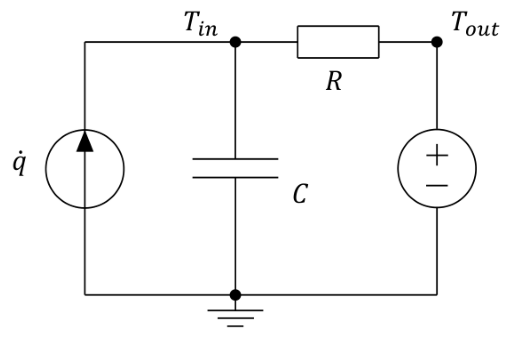

In [22]:
# Open the PDF file
pdf_document = "figures/RC_model.pdf"
doc = fitz.open(pdf_document)

# Select the page you want to display
page_number = 0
page = doc.load_page(page_number)

# Render the page to an image
pix = page.get_pixmap()

# Convert the image to a PIL Image
img = Image.open(io.BytesIO(pix.tobytes("png")))

# Display the image using Matplotlib
plt.imshow(img)
plt.axis('off')
plt.show()

The code for the heat pump models is provided below

In [2]:
import numpy as np
import gurobipy as gb 
import pandas as pd
import os
import time 

def parallel_resistance(Rarr):
    return 1 / np.sum(1 / Rarr)

In [3]:
BASE_PATH = os.getcwd()
def optimization(Tmin, Tmax, deltaT, beta_cop, Rnode, Cnode, Php_max, cP, Tamb, H):
    # Create an environment with a log file
    environment = gb.Env(BASE_PATH+"/opt_files/hp_optimization.log")

    # optimization setup 
    output_flag, presolve = 1, -1

    hpm = gb.Model(env=environment)
    hpm.setParam('OutputFlag', output_flag)
    hpm.setParam('Presolve', presolve)  # Setting presolve to conservative setting
    # add variables: comfortable rate, if the days that is between Tmin and Tmax, the comfortable rate is 1, otherwise 0
    # the total comfortable rate should >=300
    T = hpm.addVars(H, lb=15, ub=Tmax+10, name=["T_h{0}".format(h) for h in H]) # inside temperature of the buildings
    Php = hpm.addVars(H, lb=-Php_max, ub=Php_max, name=["Php_h{0}".format(h) for h in H]) # heat pump active power
    Php_abs = hpm.addVars(H, lb=0, ub=Php_max, name=["Phpabs_h{0}".format(h) for h in H]) # absolute value of the heat pump power
    Com_r = hpm.addVars(H, vtype=gb.GRB.BINARY, name=["Com_r_h{0}".format(h) for h in H]) # comfortable rate
    phi = hpm.addVar(name="objval_h0") # objective value of the optimization
    # Cnode is in MWh/K, convert it to kW/K devided by 3.6. Rnode is in K/kW
    hpm.addConstrs((( Cnode * ((T[h+1] - T[h]) / 3.6 ) == beta_cop * Php[h] - (T[h] - Tamb[h])/Rnode) 
                    for h in H[:-1]), name=["hp_power_except_last"]) # heat pump power for all hours but the last one
    hpm.addConstr(( Cnode * ((T[H[0]] - T[H[-1]]) / 3.6 ) == beta_cop * Php[H[-1]] - (T[H[-1]] - Tamb[H[-1]])/Rnode), name="hp_power_last_to_first") # heat pump power connecting the last and the first hour
    hpm.addConstrs((Php_abs[h] >= Php[h] for h in H), name=["abs_hp_power_1"]) # absolute value of the heat pump power
    hpm.addConstrs((Php_abs[h] >= -Php[h] for h in H), name=["abs_hp_power_2"]) # absolute value of the heat pump power
    hpm.addConstr((phi >= sum(cP[h] * Php_abs[h] for h in H)), name="obj_val_constraint") # objective value constraint
    hpm.addConstrs((Com_r[h] == 1 for h in H if Tmin <= T[h] <= Tmax), name=["comfortable_rate_1"]) # comfortable rate
    hpm.addConstrs((Com_r[h] == 0 for h in H if T[h] < Tmin or T[h] > Tmax), name=["comfortable_rate_2"]) # comfortable rate
    hpm.addConstr((sum(Com_r[h] for h in H) >= 300), name="comfortable_rate_3") # comfortable rate
    hpm.setObjective(phi, gb.GRB.MINIMIZE) # set the objective function

    # we print the model


    time_optimization_start = time.time()
    hpm.optimize() # Solve the model
    time_optimization_end = time.time()
    print("\n-----------------------------------------------")
    print("\nOptimization time: ", time_optimization_end - time_optimization_start)
    print("\n-----------------------------------------------")


    all_vars = hpm.getVars()
    start_vars, names = hpm.getAttr("X", all_vars), hpm.getAttr("VarName", all_vars)
    var_type = [n.split("_")[0] for n in names]
    hour_index = [int(n.split("h")[-1]) for n in names]
    df_results = pd.DataFrame({"Variable": names, "Type": var_type, "Hour": hour_index, "Value": start_vars})
    return df_results

In [16]:
def optimization(Tmin, Tmax, deltaT, beta_cop, Rnode, Cnode, Php_max, cP, Tamb, H):
    # Create an environment with a log file
    environment = gb.Env(BASE_PATH+"/opt_files/hp_optimization.log")

    # optimization setup 
    output_flag, presolve = 1, -1

    hpm = gb.Model(env=environment)
    hpm.setParam('OutputFlag', output_flag)
    hpm.setParam('Presolve', presolve)  # Setting presolve to conservative setting

    T = hpm.addVars(H, lb=Tmin, ub=Tmax, name=["T_h{0}".format(h) for h in H]) # inside temperature of the buildings
    Php = hpm.addVars(H, lb=-Php_max, ub=Php_max, name=["Php_h{0}".format(h) for h in H]) # heat pump active power
    Php_abs = hpm.addVars(H, lb=0, ub=Php_max, name=["Phpabs_h{0}".format(h) for h in H]) # absolute value of the heat pump power
    phi = hpm.addVar(name="objval_h0") # objective value of the optimization
    # Cnode is in MWh/K, convert it to kW/K devided by 3.6. Rnode is in K/kW
    hpm.addConstrs((( Cnode * ((T[h+1] - T[h]) / 3.6 ) == beta_cop * Php[h] - (T[h] - Tamb[h])/Rnode) 
                    for h in H[:-1]), name=["hp_power_except_last"]) # heat pump power for all hours but the last one
    hpm.addConstr(( Cnode * ((T[H[0]] - T[H[-1]]) / 3.6 ) == beta_cop * Php[H[-1]] - (T[H[-1]] - Tamb[H[-1]])/Rnode), name="hp_power_last_to_first") # heat pump power connecting the last and the first hour
    hpm.addConstrs((Php_abs[h] >= Php[h] for h in H), name=["abs_hp_power_1"]) # absolute value of the heat pump power
    hpm.addConstrs((Php_abs[h] >= -Php[h] for h in H), name=["abs_hp_power_2"]) # absolute value of the heat pump power
    hpm.addConstr((phi >= sum(cP[h] * Php_abs[h] for h in H)), name="obj_val_constraint") # objective value constraint

    hpm.setObjective(phi, gb.GRB.MINIMIZE) # set the objective function

    # we print the model


    time_optimization_start = time.time()
    hpm.optimize() # Solve the model
    time_optimization_end = time.time()
    print("\n-----------------------------------------------")
    print("\nOptimization time: ", time_optimization_end - time_optimization_start)
    print("\n-----------------------------------------------")


    all_vars = hpm.getVars()
    start_vars, names = hpm.getAttr("X", all_vars), hpm.getAttr("VarName", all_vars)
    var_type = [n.split("_")[0] for n in names]
    hour_index = [int(n.split("h")[-1]) for n in names]
    df_results = pd.DataFrame({"Variable": names, "Type": var_type, "Hour": hour_index, "Value": start_vars})
    return df_results


We set the parameters that are introduced in the optimization model

In [18]:
BASE_PATH = os.getcwd()
H = np.arange(8760)
# get the grid names
GRIDS = os.listdir(BASE_PATH + '/HP_allocation')
GRIDS = [grid for grid in GRIDS if grid.endswith('.csv')]
GRIDS = [grid.split('.')[0] for grid in GRIDS]
GRIDS = [grid.split('P_')[1] for grid in GRIDS]

# read temperature profiles
T_PROFILEs = pd.read_csv(BASE_PATH + '/Temperature_data/temperature_profiles.csv')

Tmin, Tmax = 18, 24
# we set the desing temperature difference
deltaT = 30 # [°C]
# we set the COP of the heat pump
beta_cop = 4.85
# we generate random data for the power price
cP = np.random.uniform(100, 120, 8760)  # [CHF/kWh]
# read the grid data
for grid in GRIDS[0:1]:
    print('Reading grid data: ', grid)
    HP_data = pd.read_csv(BASE_PATH + '/HP_allocation/HP_' + grid + '.csv')
    print('There are', HP_data.shape[0], 'nodes in the grid')
    for i in range(8,9):
        MV_osmid = HP_data.loc[i, 'MV_osmid']
        Rnode = 1/HP_data.loc[i, 'HBLD_kW/K'] # [K/kW]
        Cnode = HP_data.loc[i, 'CBLD_MWh/K'] # [MWh/K]
        PRT = HP_data.loc[i, 'PRT_MW'] # [MW]
        T_PROFILE = HP_data.loc[i, 'T_PROFILE']
        Tamb = T_PROFILEs[T_PROFILE]
        Php_max = deltaT/(beta_cop * Rnode) # [kW]
        print('The maximum power of the heat pump in node', MV_osmid, 'is', round(Php_max,2), 'kW')
        df_results = optimization(Tmin, Tmax, deltaT, beta_cop, Rnode, Cnode, Php_max, cP, Tamb, H)

Reading grid data:  0_0
There are 77 nodes in the grid
The maximum power of the heat pump in node 27 is 511.77 kW
Set parameter Username
Set parameter LogFile to value "c:\Users\14914\Desktop\lectures\SwissPDGs-TimeSeries\HP/opt_files/hp_optimization.log"
Academic license - for non-commercial use only - expires 2025-04-13
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26281 rows, 26281 columns and 70081 nonzeros
Model fingerprint: 0x5ae62292
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+01, 5e+02]
  RHS range        [8e+00, 3e+03]
Presolve removed 24143 rows and 23976 columns
Presolve time: 0.04s
Presolved: 2138 rows, 2305 columns, 6414 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and

In [19]:
df_results[df_results['Variable'].str.contains('Com')]['Value'].unique()

array([], dtype=float64)

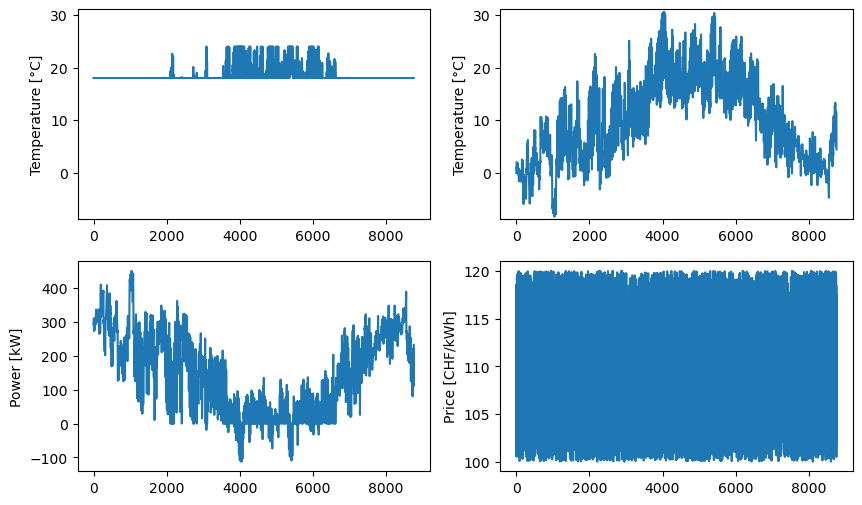

In [20]:
T_val, Php_val = df_results[df_results['Type'] == 'T']['Value'].values, df_results[df_results['Type'] == 'Php']['Value'].values

# we plot T_val, Tamb, Php_val, and cP
# the first row of the subplot will contain the temperature data
# the second row of the subplot will contain the heat pump power and the power price
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(H, T_val, label='T')
axs[0, 0].set_ylabel('Temperature [°C]')
axs[0, 0].set_ylim([np.min([Tamb.min(),T_val.min()]) - 0.5, np.max([Tamb.max(),T_val.max()]) + 0.5])
axs[0, 1].plot(H, Tamb, label='Tamb')
axs[0, 1].set_ylabel('Temperature [°C]')
axs[0, 1].set_ylim([np.min([Tamb.min(),T_val.min()]) - 0.5, np.max([Tamb.max(),T_val.max()]) + 0.5])
axs[1, 0].plot(H, Php_val, label='Php')
axs[1, 0].set_ylabel('Power [kW]')
axs[1, 1].plot(H, cP, label='cP')
axs[1, 1].set_ylabel('Price [CHF/kWh]')
plt.show()

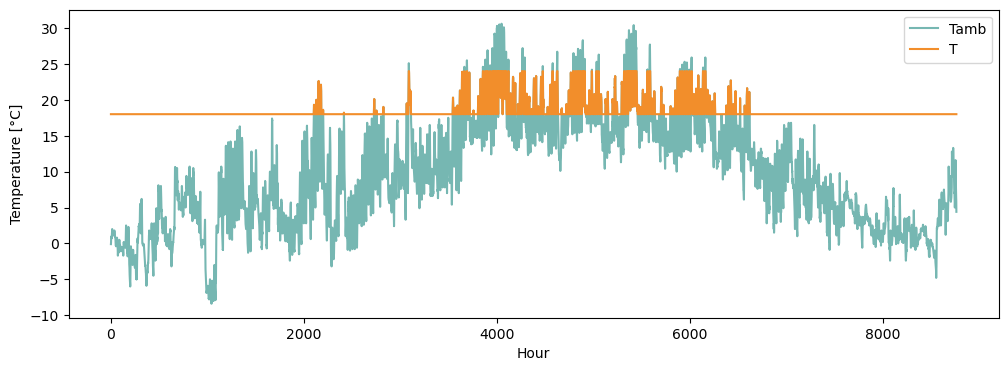

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(H, Tamb, label='Tamb', color = '#76B7B2')
plt.plot(H, T_val, label='T', color = '#F28E2B')
plt.legend()
plt.ylabel('Temperature [°C]')
plt.xlabel('Hour')
#plt.xlim([0, 24])
plt.show()

We define the model, optimize it, and recall the solutions

We plot the results